# Test 

Introduction here

In [1]:
# Typical imports here
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as c

In [2]:
import pyND.absorption as abs

In [3]:
%load_ext autoreload
%autoreload 2

## Test data

In [4]:
from scipy.io import readsav

input_filename = 'CIV1548.2i_o.save'
# input_filename = 'rbs2005_SiII1260_o.save'
spec = readsav(input_filename)

In [5]:
for kk in spec.keys(): print(kk)

v
f
ef
ion
wni
wavc
fval
gam
redshift
object
vlsr
name
ra
dec
gl
gb
z
ycon
ycon_sig
vnorm
fnorm
efnorm
efnorm1
efnorm2
sigma0
targname
sn
maxord
v1
v2
vaod1
vaod2
ncol
ncole1
ncole2
ncolez
w
w_es
w_ec
w_et
w_ez
va
vaerr
ba
baerr
m3
m3err
col3sig
col2sig
dv90
v90a
v90b
mask_cont
vel
flux
eflux


In [6]:
# FIX NON-WRITEABLE ARRAYS due to discontiguous memory
for kkk in spec.keys():
    if isinstance(spec[kkk],(np.ndarray)):
        spec[kkk] = spec[kkk].copy()

In [7]:
velocity = spec['vel'].copy()
flux = spec['flux'].copy()
flux_err = spec['eflux'].copy()
continuum = spec['ycon'].copy()
continuum_err = spec['ycon_sig'].copy()
wavc=spec['wavc'].copy()
fval=spec['fval'].copy()

(-500.0, 100.0)

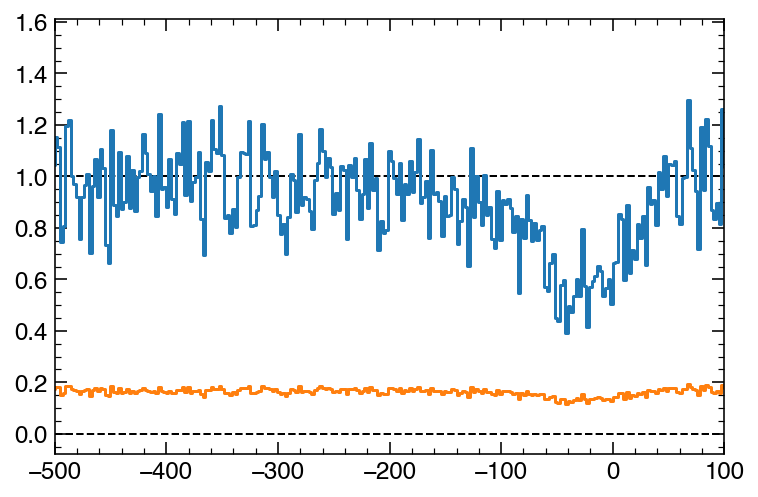

In [8]:
plt.plot(velocity,flux/continuum,drawstyle='steps-mid')
plt.plot(velocity,flux_err/continuum,drawstyle='steps-mid')
abs.plotaxes()
plt.xlim(-500,100)

### Test the new code

In [9]:
# %run pyn_column
# calc_column(velocity,flux,flux_err,
#     continuum,continuum_err,wavc,fval)

In [10]:
def fix_unwriteable_spec(spec):
    # FIX NON-WRITEABLE ARRAYS due to discontiguous memory
    for kkk in spec.keys():
        if isinstance(spec[kkk],(np.ndarray)):
            spec[kkk] = spec[kkk].copy()

    return spec

def xlimit(x, limits):

   def _ret():  return idx1, idx2

   # x1 = where(ravel(x >= xpos1))[0]  ;  x1 = x1[0]
   # x2 = where(ravel(x > xpos2))[0]  ;  x2 = x2[0] - 1

   idx1 = (np.abs(x - limits[0])).argmin()
   idx2 = (np.abs(x - limits[1])).argmin()

   return _ret()

In [11]:
integration_limits=[spec['v1'],spec['v2']]
integration_limits=[-300,-150]

In [12]:
    # Some constants and flags
    column_factor = 2.654e-15
    flag_sat = False

    velocity = spec['vel'].copy()
    flux = spec['flux'].copy()
    flux_err = spec['eflux'].copy()
    continuum = spec['ycon'].copy()
    continuum_err = spec['ycon_sig'].copy()
    wavc=spec['wavc'].copy()
    fval=spec['fval'].copy()

    # Define the limits of the integration:
    if not integration_limits:
        int_idx = np.full(np.size(velocity),False)
        xlim1, xlim2 = \
            xlimit(velocity,[spec['v1'],spec['v2']])
        int_idx[xlim1:xlim2] = True
    else:
        int_idx = np.full(np.size(velocity),False)
        xlim1, xlim2 = \
            xlimit(velocity,integration_limits)
        int_idx[xlim1:xlim2] = True

    #Define the velocity spacing
    delv = np.median(velocity[1:]-velocity[:-1])

    # Test for clearly saturated pixels:
    idx_saturation = (flux <= 0.)
    if idx_saturation.sum() > 0: flag_sat = True

    # Fix saturation if it's present.
    flux[idx_saturation] = np.abs(flux[idx_saturation])
    flux[(flux==0)] = 2.*flux_err[(flux==0)]

    # Create an optical depth array and its error
    tau_array = np.log(continuum / flux)
    tau_array_err = np.sqrt((flux_err/flux)**2)

    tau_int = np.sum(tau_array[int_idx]*delv)
    tau_int_err = \
     np.sqrt(np.sum((tau_array_err[int_idx]*delv)**2))

    # Create an apparent column density array
    nav_array = tau_array/(wavc*fval*column_factor)
    nav_err = tau_array_err/(wavc*fval*column_factor)

    # Integrate the apparent column density profiles
    column = tau_int/(wavc*fval*column_factor)

    # Error in the column
    column_err = tau_int_err/(wavc*fval*column_factor)

    # Continuum error
    column_err_cont = \
        np.sum(((continuum_err[int_idx]/continuum[int_idx])*delv)) /\
         (wavc*fval*column_factor)

    # Background uncertainty
    z_eps = 0.01  # Fractional bg error
    yc1 = continuum[int_idx]*(1.-z_eps)
    y1  = flux[int_idx]-continuum[int_idx]*z_eps
    tau1 = np.sum(np.log(yc1/y1)*delv)
    col1 = tau1 / (wavc*fval*column_factor)
    column_err_zero = np.abs(col1-column)

    # Combine errors
    column_err_total = np.sqrt(column_err**2 \
        +column_err_cont**2)



In [13]:
np.log10(column),column_err/column*np.log10(np.e)

(13.09315733229834, 0.15186661302157617)

#### $\tau_a(v)$ profile

(-1.0, 5.0)

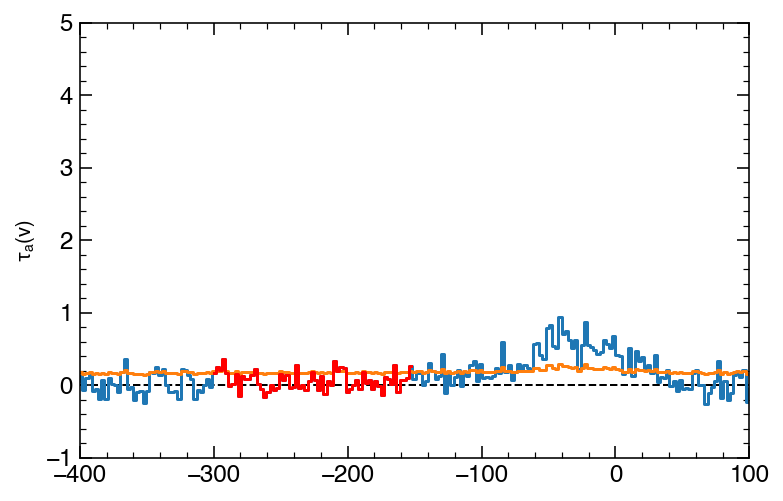

In [14]:
plt.plot(velocity,tau_array,drawstyle='steps-mid')
plt.plot(velocity,tau_array_err,drawstyle='steps-mid')
plt.plot(velocity[int_idx],tau_array[int_idx],color='red',drawstyle='steps-mid')
abs.plotzero()
plt.ylabel('$\\tau_a(v)$')
plt.xlim(-400,100)
plt.ylim(-1,5)

#### $N_a(v)$ profile

(-100000000000.0, 1000000000000.0)

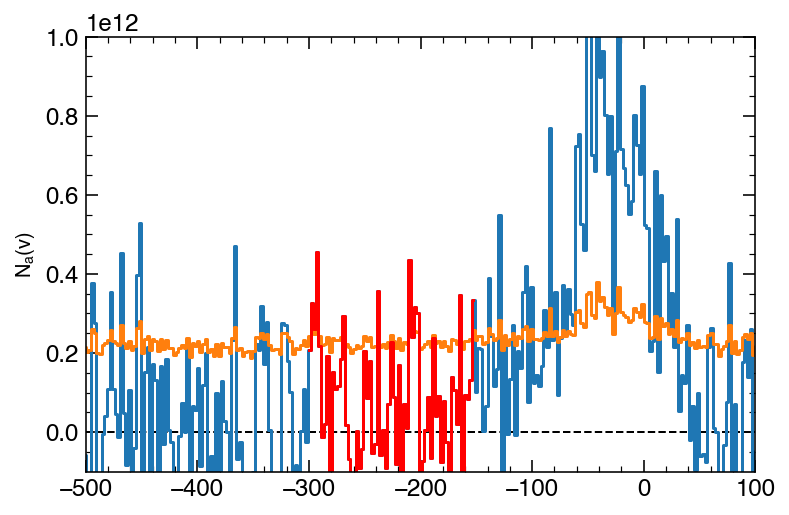

In [15]:
plt.plot(velocity,nav_array,drawstyle='steps-mid')
plt.plot(velocity,nav_err,drawstyle='steps-mid')
plt.plot(velocity[int_idx],nav_array[int_idx],color='red',drawstyle='steps-mid')
abs.plotzero()
plt.ylabel('$N_a(v)$')
plt.xlim(-500,100)
plt.ylim(-0.1e12,1e12)

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


```

```
# Testing `pyNorm.aod.pyn_column`

In [17]:
from scipy.io import readsav

input_filename = 'CIV1548.2i_o.save'
# input_filename = 'rbs2005_SiII1260_o.save'
spec = readsav(input_filename)

In [18]:
integration_limits=[spec['v1'],spec['v2']]
integration_limits=[-300,-150]

In [19]:
from pyNorm.aod import pyn_column

#### Calculate the column density using the velocity limits in the save file

In [20]:
spec_out = pyn_column(spec)
spec_out['ncol'], spec_out['necol1']

(12.71548152402164, 0.26729178703803785)

#### Calculate the column density using the velocity limits from above

In [21]:
spec_out = pyn_column(spec,integration_limits)
spec_out['ncol'], spec_out['necol1']

(13.093897958798385, 0.15486311615601664)

#### Calculate the column density using arbitrary limits

In [22]:
spec_out = pyn_column(spec,integration_limits = [-100,-50])
spec_out['ncol'], spec_out['necol1']

(13.229653986262422, 0.07196024006842763)

# Test EW code

In [23]:
integration_limits = [-295,-215]
# FIX NON-WRITEABLE ARRAYS due to discontiguous
# memory in some readsav inputs
if ~spec['vel'].flags.writeable:
    spec = fix_unwriteable_spec(spec)

# Some constants and flags
column_factor = 2.654e-15
lightspeed = 2.998e5 # km/s
flag_sat = False

velocity = spec['vel'].copy()
flux = spec['flux'].copy()
flux_err = spec['eflux'].copy()
wavc=spec['wavc'].copy()
fval=spec['fval'].copy()

# Deal with the continuum:
try:
    continuum=spec['ycon'].copy()
    continuum_err = spec['ycon_sig'].copy()
except:
    continuum=spec['cont']
    continuum_err = spec['econt'].copy()


# Define the limits of the integration:
if not integration_limits:
    integration_limits = [spec['v1'],spec['v2']]
    int_idx = np.full(np.size(velocity),False)
    xlim1, xlim2 = \
        xlimit(velocity,[spec['v1'],spec['v2']])
    int_idx[xlim1:xlim2] = True
else:
    int_idx = np.full(np.size(velocity),False)
    xlim1, xlim2 = \
        xlimit(velocity,integration_limits)
    int_idx[xlim1:xlim2] = True

#Define the velocity spacing
delv = np.median(velocity[1:]-velocity[:-1])

# Create the wavelength array
try:
    wave=spec['wave'].copy()
except:
    wave = spec['wavc']*(velocity/lightspeed)+wavc
    spec['wave'] = wave

# Wavelength spacing
delw = np.median(wave[1:]-wave[:-1])

# Calculate the equivalent width
eqw_int = np.sum((1.-flux[int_idx]/continuum[int_idx])*delw)

# Random flux errors
eqw_stat_err = \
    np.sqrt(np.sum((flux_err[int_idx]/continuum[int_idx]*delw)**2))
# Continuum errors
eqw_cont_err = \
    np.sum(continuum_err[int_idx]*(flux[int_idx]/continuum[int_idx]**2)*delw)
# Zero point error
# TODO: Check this calculation
z_eps = 0.01
eqw_zero_err = z_eps*eqw_int

# Combine errors
eqw_err = np.sqrt(eqw_stat_err**2 \
    +eqw_cont_err**2 + eqw_zero_err**2)

spec['v1'] = integration_limits[0]
spec['v2'] = integration_limits[1]

# Store the EW in milliAngstrom
spec['EW'] = eqw_int*1000.
spec['EW_err'] = eqw_err*1000.
spec['EW_stat_err'] = eqw_stat_err*1000.
spec['EW_cont_err'] = eqw_cont_err*1000.
spec['EW_zero_err'] = eqw_zero_err*1000.

spec['EW_cumulative'] = \
  np.cumsum((1.-flux[int_idx]/continuum[int_idx])*delw)*1000.

#     try:
#         del spec['w']
#         del spec['w_es']
#         del spec['w_ec']
#         del spec['w_et']
#         del spec['w_ez']
#     except:
#         pass

In [24]:
eqw_int*1000.,eqw_err*1000.

(17.42219366133213, 12.190187396508447)

### EW cumulative integration

Text(0, 0.5, 'Cumulative EW (milliAngstrom)')

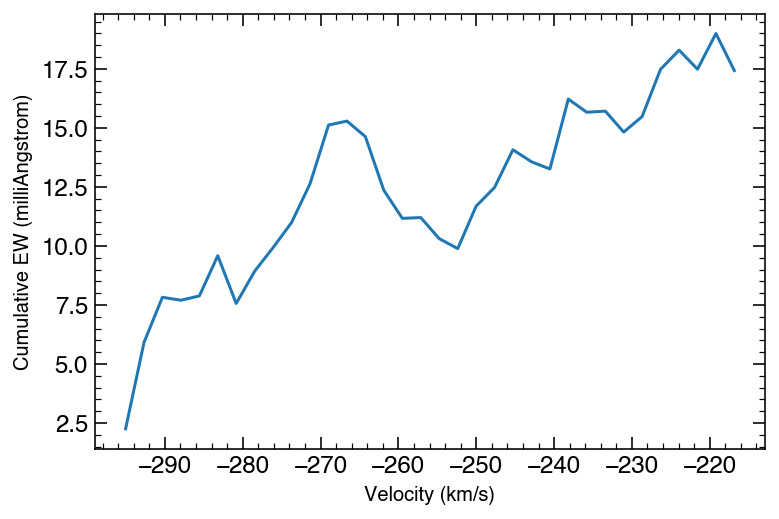

In [25]:
eqw_cum = spec['EW_cumulative']
plt.plot(velocity[int_idx],eqw_cum)
plt.xlabel('Velocity (km/s)')
plt.ylabel('Cumulative EW (milliAngstrom)')

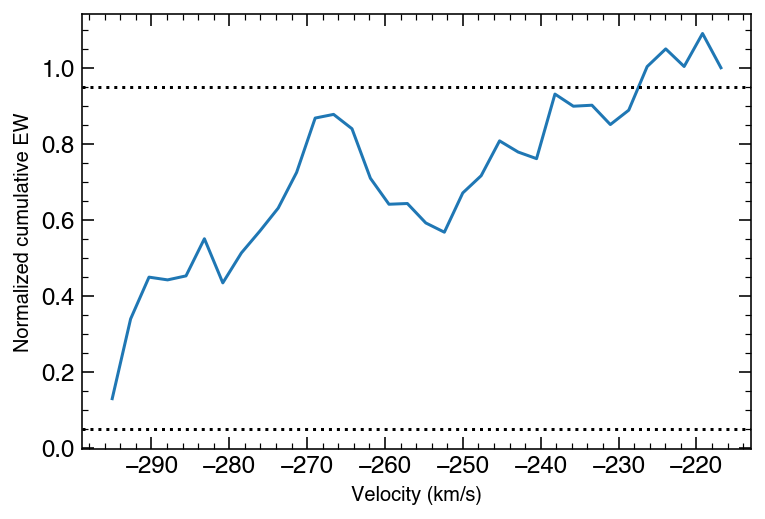

In [26]:
plt.plot(velocity[int_idx],eqw_cum/eqw_cum[-1])
plt.xlabel('Velocity (km/s)')
plt.ylabel('Normalized cumulative EW')
plt.axhline(0.05,linestyle=':',color='k')
plt.axhline(0.95,linestyle=':',color='k')

```

```
# Testing `pyNorm.aod.pyn_eqwidth`

In [27]:
from scipy.io import readsav

input_filename = 'CIV1548.2i_o.save'
# input_filename = 'rbs2005_SiII1260_o.save'
spec = readsav(input_filename)

In [28]:
integration_limits=[spec['v1'],spec['v2']]
integration_limits=[-295,-215]

In [29]:
from pyNorm.aod import pyn_eqwidth
from pyNorm.aod import pyn_column

#### Calculate the column density using the velocity limits in the save file

In [30]:
spec_out = pyn_column(spec)
spec_out = pyn_eqwidth(spec_out)
spec_out['EW'], spec_out['EW_err']

(17.42052467650511, 12.223810162578102)

#### Calculate the column density using the velocity limits from above

In [31]:
spec_out = pyn_column(spec, integration_limits)
spec_out = pyn_eqwidth(spec_out, integration_limits)
spec_out['EW'], spec_out['EW_err']

(17.42052467650511, 12.223810162578102)

#### Calculate the column density using arbitrary limits

In [32]:
spec_out = pyn_eqwidth(spec,integration_limits = [-100,50])
spec_out['EW'], spec_out['EW_err']

(225.45429693894837, 14.900590492499548)

# Testing statistics code

In [33]:
from scipy.io import readsav

input_filename = 'CIV1548.2i_o.save'
# input_filename = 'rbs2005_SiII1260_o.save'
spec = readsav(input_filename)

In [34]:
    # FIX NON-WRITEABLE ARRAYS due to discontiguous
    # memory in some readsav inputs
    if ~spec['vel'].flags.writeable:
        spec = fix_unwriteable_spec(spec)

    # Some constants and flags
    column_factor = 2.654e-15
    ew_factor = 1.13e17
    lightspeed = 2.998e5 # km/s
    flag_sat = False

    velocity = spec['vel'].copy()
    flux = spec['flux'].copy()
    flux_err = spec['eflux'].copy()
    wavc=spec['wavc'].copy()
    fval=spec['fval'].copy()

    # Deal with the continuum:
    try:
        continuum=spec['ycon'].copy()
        continuum_err = spec['ycon_sig'].copy()
    except:
        continuum=spec['cont']
        continuum_err = spec['econt'].copy()

    # Define the limits of the integration:
    if not integration_limits:
        integration_limits = [spec['v1'],spec['v2']]
        idx = np.full(np.size(velocity),False)
        xlim1, xlim2 = \
            xlimit(velocity,[spec['v1'],spec['v2']])
        idx[xlim1:xlim2] = True
    else:
        idx = np.full(np.size(velocity),False)
        xlim1, xlim2 = \
            xlimit(velocity,integration_limits)
        idx[xlim1:xlim2] = True

    # An array of delta v:
    delv = velocity[1:]-velocity[:-1]
    delv = np.concatenate((delv,[delv[-1]]))

    # TODO: Saturation?
    # Calculate the zeroth moment
    tau = np.log(np.abs(continuum/flux))
    tau_tot = np.sum(tau[idx]*delv[idx])

    # Calculate the first moment (average velocity)
    a = np.sum(tau[idx]*velocity[idx]*delv[idx])
    m1 = a/tau_tot

    # Calculate the second moment (width)
    b = np.sum(tau[idx]*(velocity[idx] - m1)**2*delv[idx])
    m2 = np.sqrt(b/tau_tot)

    # Calculate the third moment (skewness)
    c = np.sum(tau[idx]*((velocity[idx] - m1)/m2)**3*delv[idx])
    m3 = c/tau_tot

    # Calculate the extent (same as m2, except that m1 is assumed to be 0)
    b4 = np.sum(tau[idx]*(velocity[idx] - 0)**2*delv[idx])
    m4 = np.sqrt(b4/tau_tot)

    # Velocities at 5% and 95% of total optical depth as dv90
    tau_cum = np.cumsum(tau[idx]*delv[idx])
    v90a = (tau_cum/tau_tot-0.05).argmin()

In [35]:
v90a

0

```

```
# Testing `pyn_istat`

In [36]:
from scipy.io import readsav

input_filename = 'CIV1548.2i_o.save'
# input_filename = 'rbs2005_SiII1260_o.save'
spec = readsav(input_filename)

In [37]:
integration_limits=[spec['v1'],spec['v2']]
integration_limits=[-295,-215]

In [38]:
from pyNorm.aod import pyn_eqwidth
from pyNorm.aod import pyn_column
from pyNorm.aod import pyn_istat

#### Calculate the column density using the velocity limits in the save file

In [39]:
spec_out = pyn_column(spec)
spec_out = pyn_eqwidth(spec_out)
spec_out = pyn_istat(spec_out)
print(spec_out['va'], spec_out['va_err'])
print(spec_out['dv90'], spec_out['v90a'],spec_out['v90b'])


-270.95096463798683 16.880205667897602
56.87149388349741 -295.04040504322205 -238.16891115972464


```

```
# Testing `pyn_batch`

In [40]:
from scipy.io import readsav

input_filename = 'CIV1548.2i_o.save'
# input_filename = 'rbs2005_SiII1260_o.save'
spec = readsav(input_filename)

In [43]:
integration_limits=[spec['v1'],spec['v2']]
integration_limits=[-200,100]

In [45]:
from pyNorm.aod import pyn_eqwidth
from pyNorm.aod import pyn_column
from pyNorm.aod import pyn_istat
from pyNorm.aod import pyn_batch

#### Calculate the column density using the velocity limits in the save file

In [46]:
spec_out = pyn_batch(spec,integration_limits)

pyn_batch: Wavelength = 1548.204
pyn_batch: f-value = 0.190

--------------------------------------------
log N = 13.921 (-0.037, +0.037)
--------------------------------------------

--------------------------------------------
<v>       = -43.15  +/- 6.68
<b>       =  48.98  +/- 6.62
dv90      = 165.91  +/- 9.45
Skew      =  -0.53  +/- 0.87
--------------------------------------------

--------------------------------------------
EW           = 265.77
Stat Error   = 21.91
Cont Error   = 5.85
Tot Error    = 22.84
3sigma EW    < 68.51


Linear COG N = 13.82
3sigma N     < 13.23
2sigma N     < 13.05
--------------------------------------------


# Legendre continuum

In [60]:
    x = spec['vel'].copy()
    y = spec['flux'].copy()


    nflag = 0
    nord = maxord
    #
    #Array subscript length and vector.
    #
    nx = x.size
    ix = np.arange(nx)

    #Form legendre polynomial.
    p = np.zeros([maxord + 1, nx])
    p[ix] = 1.
    p[ix + nx] = x
    for j in np.arange(2., (maxord)+(1)):
        p[ix + j * nx] = ((2. * j - 1.) * x * p[j - 1,:] - (j - 1) * p[j - 2,:]) / j


IndexError: index 4 is out of bounds for axis 0 with size 4